# Data Visualisation Methods
This notebook provides data visualisation methods for the CSV files in the `data` folder. It uses pandas and matplotlib/seaborn for analysis and plotting.

In [1]:
# Import required libraries
from __future__ import annotations

import os

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
# List CSV files in the data folder
data_folder = "../data"
csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]
print("CSV files:", csv_files)

trips = pd.read_csv(Path("../data/ride_trips.csv"), low_memory=False)

trips.head()

CSV files: ['customers.csv', 'riders.csv', 'README.csv', 'surge_by_hour.csv', 'jobs_like.csv', 'heatmap.csv', 'eats_orders.csv', 'ride_trips.csv', 'weather_daily.csv', 'merchants.csv', 'cancellation_rates.csv', 'earnings_daily.csv', 'earners.csv', 'incentives_weekly.csv']


,ride_id,driver_id,rider_id,city_id,product,vehicle_type,is_ev,start_time,end_time,pickup_lat,...,drop_hex_id9,distance_km,duration_mins,surge_multiplier,fare_amount,uber_fee,net_earnings,tips,payment_type,date
0,58e20c15-9b2e-4458-ac00-107bcf9564cd,E10111,R2231,3,UberX,car,False,2023-01-13 23:50:00,2023-01-14 00:10:00,52.09319,...,896326c3e14b5c2,9.00,20,1.22,17.54,4.38,13.16,0.00,cash,2023-01-13
1,e02cff2b-bb4f-4b76-a97a-a2cca9477275,E10152,R2133,4,UberX,car,False,2023-02-10 05:13:00,2023-02-10 05:25:00,51.41972,...,898e2394712bd2c,4.79,12,1.01,8.48,2.12,6.36,1.80,card,2023-02-10
2,779d0691-f33d-4d00-991b-983d3171e420,E10157,R2534,3,UberPool,car,True,2023-02-25 18:27:00,2023-02-25 18:53:00,52.05469,...,8947d4823562561,6.59,26,1.36,12.87,3.22,9.65,0.00,card,2023-02-25
3,b08070cf-4a5f-432f-a04d-4fa35382aa87,E10024,R2265,2,UberGreen,car,True,2023-02-20 23:58:00,2023-02-21 00:24:00,51.94535,...,89cf8728790df33,8.24,26,1.22,17.96,4.49,13.47,0.51,wallet,2023-02-20
4,c5479c2b-d878-4986-bc0c-112284e8c495,E10146,R2126,3,UberX,car,True,2023-01-16 18:42:00,2023-01-16 19:13:00,52.10560,...,8900b3581cd6ec3,7.50,31,1.36,17.15,4.29,12.86,0.00,wallet,2023-01-16


In [21]:
def plot_city_rides(df, city_id):
  """Plot all pickup and dropoff points for a given city_id."""
  required = ["city_id", "pickup_lat", "pickup_lon", "drop_lat", "drop_lon"]
  missing = [c for c in required if c not in df.columns]
  if missing:
    print(f"Missing required columns in CSV: {missing}")
    print(f"Available columns: {list(df.columns)}")
    return

  sub = df[df["city_id"] == city_id].copy()
  if sub.empty:
    print(f"No rows for city_id={city_id}.")
    return

  plt.figure(figsize=(12, 12))
  # Plot pickups in blue
  plt.scatter(sub["pickup_lon"], sub["pickup_lat"], s=1, alpha=0.5, c="blue", label="Pickup Points")
  # Plot dropoffs in red
  plt.scatter(sub["drop_lon"], sub["drop_lat"], s=1, alpha=0.5, c="red", label="Dropoff Points")

  plt.title(f"Pickup and Dropoff Points - City {city_id}")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.legend()

  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

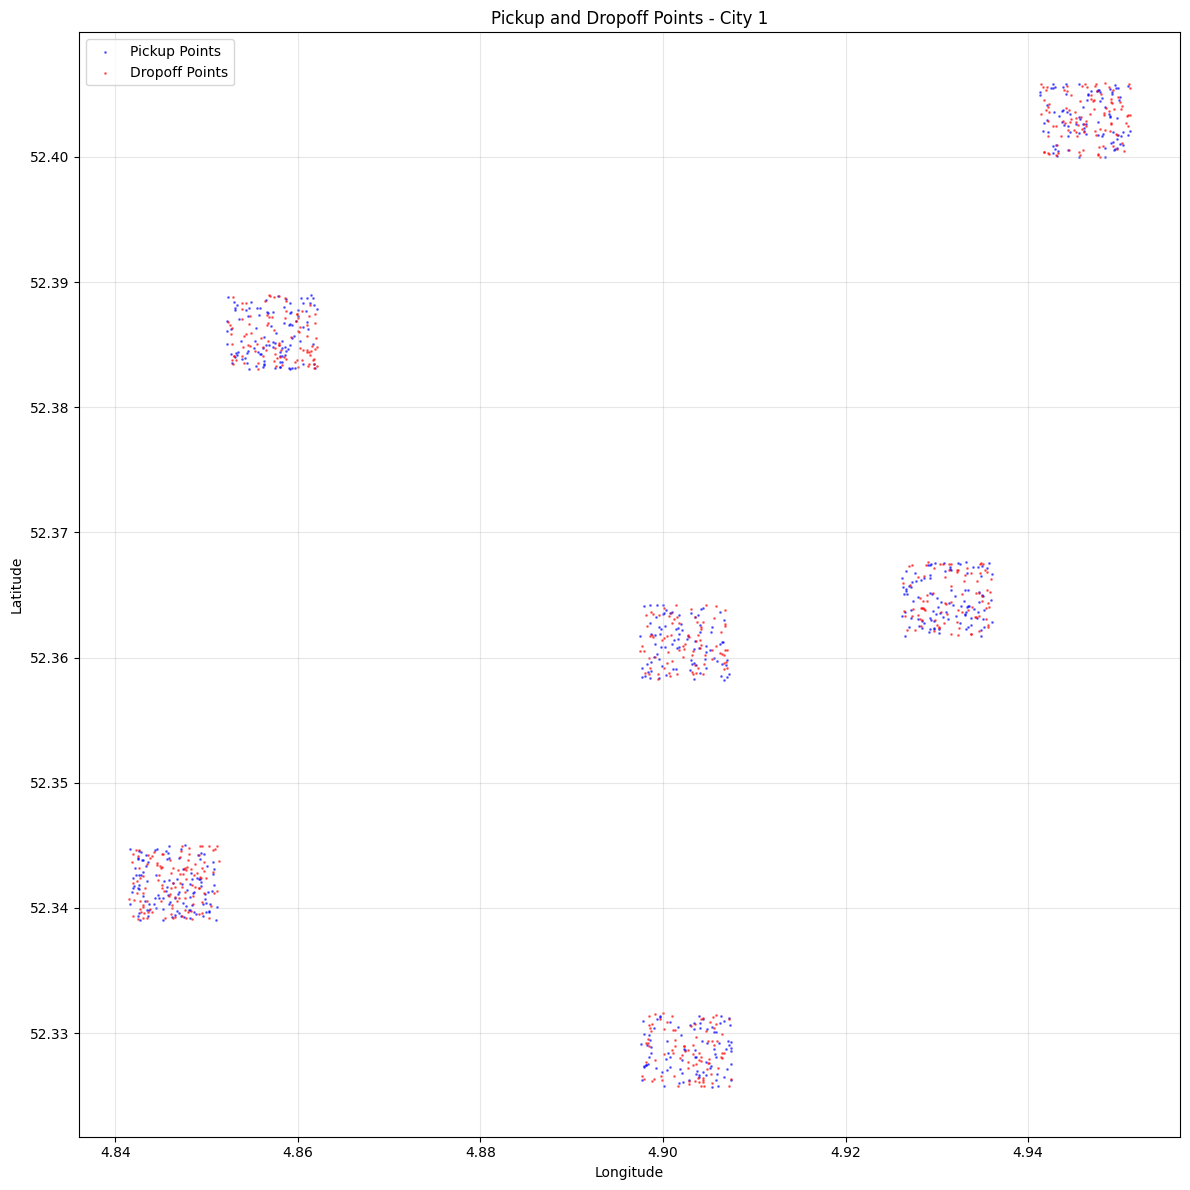

In [22]:
# Try the new plotting function with both pickup and dropoff points
plot_city_rides(trips, 1)

In [4]:
from pathlib import Path

import pandas as pd

from sklearn.cluster import DBSCAN


def cluster_pickups_and_dropoffs_by_city(
  df: pd.DataFrame,
  *,
  city_col: str = "city_id",
  plat_col: str = "pickup_lat",
  plon_col: str = "pickup_lon",
  dlat_col: str = "drop_lat",
  dlon_col: str = "drop_lon",
  eps_m: float = 250.0,
  min_samples: int = 10,
  save_dir: Path | str = "city_cluster_plots",
  label_noise_as: str = "noise",  # or "-1" if you prefer
):
  """Cluster rides per city, using BOTH pickup and dropoff points.

  For each city:
    - Build one point set by stacking pickup and dropoff points (valid coords only).
    - Run DBSCAN with haversine distance.
    - Assign each row two labels:
        pickup_cluster  -> "c_<city>_<clusterID>" or "c_<city>_noise"
        dropoff_cluster -> "c_<city>_<clusterID>" or "c_<city>_noise"
    - Save one scatter plot per city (all points colored by cluster).

  Returns
  -------
  out_df : DataFrame
      A copy of df with new string columns: 'pickup_cluster', 'dropoff_cluster'.
  plot_paths : dict
      { city_value: path_to_png }

  """
  # Validate required columns
  for c in (city_col, plat_col, plon_col, dlat_col, dlon_col):
    if c not in df.columns:
      raise ValueError(f"Missing required column '{c}'. Columns present: {list(df.columns)}")

  out = df.copy()

  # Prepare output columns
  out["pickup_cluster"] = pd.NA
  out["dropoff_cluster"] = pd.NA

  # Keep only rows with valid city id
  valid_city_mask = out[city_col].notna()
  if not valid_city_mask.any():
    raise ValueError("No rows with a valid city id.")

  # Setup plotting output
  save_dir = Path(save_dir) if save_dir is not None else None
  if save_dir is not None:
    save_dir.mkdir(parents=True, exist_ok=True)

  # eps (meters) -> radians for haversine
  eps_rad = eps_m / 6_371_000.0  # Earth radius in meters

  plot_paths = {}
  all_cities = np.sort(out.loc[valid_city_mask, city_col].unique())

  for city in all_cities:
    city_idx = out.index[out[city_col] == city]

    # Build coordinate arrays for pickups and dropoffs (valid only)
    pick_mask = out.loc[city_idx, plat_col].between(-90, 90) & out.loc[city_idx, plon_col].between(
      -180, 180
    )
    drop_mask = out.loc[city_idx, dlat_col].between(-90, 90) & out.loc[city_idx, dlon_col].between(
      -180, 180
    )

    pick_idx = city_idx[pick_mask.values]
    drop_idx = city_idx[drop_mask.values]

    # Nothing to cluster?
    if len(pick_idx) == 0 and len(drop_idx) == 0:
      continue

    # Stack both sets (each trip may contribute up to 2 points)
    parts = []
    if len(pick_idx) > 0:
      parts.append(out.loc[pick_idx, [plat_col, plon_col]].to_numpy(dtype=float))
    if len(drop_idx) > 0:
      parts.append(out.loc[drop_idx, [dlat_col, dlon_col]].to_numpy(dtype=float))

    coords_deg = np.vstack(parts)  # shape (N_total_points, 2)
    coords_rad = np.radians(coords_deg)

    # Fit DBSCAN on the union of points
    db = DBSCAN(
      eps=eps_rad,
      min_samples=min_samples,
      metric="haversine",
      algorithm="ball_tree",
    )
    labels_all = db.fit_predict(coords_rad)  # -1 = noise

    # Split labels back to pickup/dropoff sets in their original row indices
    n_pick = len(pick_idx)
    pick_labels = labels_all[:n_pick] if n_pick > 0 else np.array([], dtype=int)
    drop_labels = labels_all[n_pick:] if len(drop_idx) > 0 else np.array([], dtype=int)

    # Helper to stringify labels per spec c_<city>_<clusterID/noise>
    def fmt(lbl: int) -> str:
      if lbl == -1:
        tag = label_noise_as
      else:
        tag = str(lbl)
      return f"c_{city}_{tag}"

    # Write pickup cluster labels
    if n_pick > 0:
      out.loc[pick_idx, "pickup_cluster"] = [fmt(int(x)) for x in pick_labels]

    # Write dropoff cluster labels
    if len(drop_idx) > 0:
      out.loc[drop_idx, "dropoff_cluster"] = [fmt(int(x)) for x in drop_labels]

    # Plot one figure per city with ALL points, colored by cluster
    if save_dir is not None:
      plt.figure(figsize=(8, 8))
      unique_labels = np.unique(labels_all)

      # Pickup points first
      if n_pick > 0:
        for ul in unique_labels:
          mask_ul = pick_labels == ul
          if mask_ul.any():
            pts = coords_deg[:n_pick][mask_ul]
            lbl_name = "noise" if ul == -1 else f"cluster {ul}"
            plt.scatter(pts[:, 1], pts[:, 0], s=6, label=f"pickup {lbl_name}")

      # Dropoff points next
      if len(drop_idx) > 0:
        offs = coords_deg[n_pick:]
        for ul in unique_labels:
          mask_ul = drop_labels == ul
          if mask_ul.any():
            pts = offs[mask_ul]
            lbl_name = "noise" if ul == -1 else f"cluster {ul}"
            # no explicit color; matplotlib cycles but same label text differs
            plt.scatter(pts[:, 1], pts[:, 0], s=6, marker="x", label=f"dropoff {lbl_name}")

      plt.title(
        f"DBSCAN clusters on pickup+dropoff (eps={eps_m}m, min_samples={min_samples}) — {city_col}={city}"
      )
      plt.xlabel("Longitude")
      plt.ylabel("Latitude")

      # Keep legend readable if not too many entries
      handles, labels_txt = plt.gca().get_legend_handles_labels()
      if len(labels_txt) <= 24:
        plt.legend(markerscale=2, fontsize=8, loc="best")

      plt.tight_layout()
      png_path = save_dir / f"city_{city}_clusters_pick_drop.png"
      plt.savefig(png_path, dpi=150)
      plt.close()
      plot_paths[city] = str(png_path)

  return out, plot_paths

In [5]:
from pathlib import Path

import pandas as pd

trips = pd.read_csv(Path("../data/ride_trips.csv"), low_memory=False)

labeled, plots = cluster_pickups_and_dropoffs_by_city(
  trips,
  city_col="city_id",
  plat_col="pickup_lat",
  plon_col="pickup_lon",
  dlat_col="drop_lat",
  dlon_col="drop_lon",
  eps_m=250,  # adjust to your city scale
  min_samples=10,  # lower if you want smaller clusters
  save_dir=Path("../data/city_cluster_plots"),  # folder with per-city PNGs
)

# The two new columns you asked for:
labeled[["pickup_cluster", "dropoff_cluster"]].head()
labeled.to_csv("../data/ride_trips_with_clusters.csv", index=False)

# See where plots were saved
plots

{np.int64(1): '../data/city_cluster_plots/city_1_clusters_pick_drop.png',
 np.int64(2): '../data/city_cluster_plots/city_2_clusters_pick_drop.png',
 np.int64(3): '../data/city_cluster_plots/city_3_clusters_pick_drop.png',
 np.int64(4): '../data/city_cluster_plots/city_4_clusters_pick_drop.png',
 np.int64(5): '../data/city_cluster_plots/city_5_clusters_pick_drop.png'}

In [3]:
labeled.head()

,ride_id,driver_id,rider_id,city_id,product,vehicle_type,is_ev,start_time,end_time,pickup_lat,...,duration_mins,surge_multiplier,fare_amount,uber_fee,net_earnings,tips,payment_type,date,pickup_cluster,dropoff_cluster
0,58e20c15-9b2e-4458-ac00-107bcf9564cd,E10111,R2231,3,UberX,car,False,2023-01-13 23:50:00,2023-01-14 00:10:00,52.09319,...,20,1.22,17.54,4.38,13.16,0.00,cash,2023-01-13,c_3_0,c_3_4
1,e02cff2b-bb4f-4b76-a97a-a2cca9477275,E10152,R2133,4,UberX,car,False,2023-02-10 05:13:00,2023-02-10 05:25:00,51.41972,...,12,1.01,8.48,2.12,6.36,1.80,card,2023-02-10,c_4_0,c_4_3
2,779d0691-f33d-4d00-991b-983d3171e420,E10157,R2534,3,UberPool,car,True,2023-02-25 18:27:00,2023-02-25 18:53:00,52.05469,...,26,1.36,12.87,3.22,9.65,0.00,card,2023-02-25,c_3_1,c_3_2
3,b08070cf-4a5f-432f-a04d-4fa35382aa87,E10024,R2265,2,UberGreen,car,True,2023-02-20 23:58:00,2023-02-21 00:24:00,51.94535,...,26,1.22,17.96,4.49,13.47,0.51,wallet,2023-02-20,c_2_0,c_2_2
4,c5479c2b-d878-4986-bc0c-112284e8c495,E10146,R2126,3,UberX,car,True,2023-01-16 18:42:00,2023-01-16 19:13:00,52.10560,...,31,1.36,17.15,4.29,12.86,0.00,wallet,2023-01-16,c_3_2,c_3_3


In [1]:
import pandas as pd
from datetime import timedelta

def train_weather_model(weather_df):
    """Compute transition probabilities P(next | current) per city."""
    transitions = {}
    for city, group in weather_df.groupby("city_id"):
        group = group.sort_values("date")
        group["next_weather"] = group["weather"].shift(-1)
        trans = (
            group.groupby(["weather", "next_weather"])
            .size()
            .unstack(fill_value=0)
            .apply(lambda x: x / x.sum(), axis=1)
        )
        transitions[city] = trans
    return transitions

def predict_weather(city_id, target_date, weather_df, transitions):
    """Predict next weather for city_id on target_date using transition probs."""
    weather_df["date"] = pd.to_datetime(weather_df["date"])
    target_date = pd.to_datetime(target_date)

    # Get last known weather before target date
    recent = weather_df[(weather_df["city_id"] == city_id) & (weather_df["date"] < target_date)]
    if recent.empty:
        # fallback to most frequent
        most_common = weather_df[weather_df["city_id"] == city_id]["weather"].mode()[0]
        return most_common

    last_weather = recent.sort_values("date").iloc[-1]["weather"]

    # Transition-based prediction
    if city_id in transitions and last_weather in transitions[city_id].index:
        probs = transitions[city_id].loc[last_weather]
        if not probs.empty:
            return probs.idxmax()  # most probable next weather

    # Fallback: most frequent weather
    return recent["weather"].mode()[0]


In [8]:
weather_df = pd.read_csv("../data/weather_daily.csv")
transitions = train_weather_model(weather_df)

city = 2
date = "2025-05-01"
pred = predict_weather(city, date, weather_df, transitions)
print(pred)

clear
